In [230]:
import keras
keras.__version__

'2.2.4'

In [262]:
https://www.researchgate.net/profile/Francesco_Virili/publication/3857945_Nonstationarity_and_data_preprocessing_for_neural_network_predictions_of_an_economic_time_series/links/02bfe50d19e7cae318000000/Nonstationarity-and-data-preprocessing-for-neural-network-predictions-of-an-economic-time-series.pdf

SyntaxError: invalid syntax (<ipython-input-262-935280bd612f>, line 1)

In [545]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas import Series
from pandas import DataFrame
from pandas import concat

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Flatten
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, History, LearningRateScheduler
from keras.optimizers import Adam
from keras.models import load_model

from keras import optimizers
from keras import metrics

from statistics import median
from statistics import mean

%matplotlib inline
#%matplotlib notebook

plt.style.use('fivethirtyeight')

import matplotlib.dates as mdates


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import math
#from math import sqrt

from matplotlib import pyplot
from numpy import array

from datetime import datetime

# date-time parsing function
def date_parser(d):
    try:
        d = datetime.strptime(d, "%b %d, %y")
    except ValueError:
        try:
            # TODO: try some alternate format spec
            d = datetime.strptime("format 2")
        except:
            # both formats not match, do something about it
            raise ValueError()
    return d


# adjusted R2:
# increases only if an additional predictor improves the model
# more than would be expected by chance
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))


# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# convert time series into supervised learning problem
def series_to_supervised(data, idx, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
#	df = DataFrame(data)
	df = DataFrame(data, columns=["data"]).set_index(idx)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# transform series into sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	idx = series.index

	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values
	scaler = MinMaxScaler(feature_range=(-1, 1))
#	scaler = StandardScaler()#with_mean=False,with_std=False)
#	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaler.fit_transform(raw_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
#	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised = series_to_supervised(scaled_values, idx, n_lag, n_seq)
	supervised_values = supervised.values
	index = supervised.index
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, supervised, index

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

In [519]:
# Exchange rate data 1 USD = X INRs
exchange_data = pd.read_csv('USD_INR.csv')
# Convert string to datatime, set dataframe index
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
inr = exchange_data.set_index(["Date"], drop=True)
inr.head()

,Price,Open,High,Low,Change %
Date,,,,,
2017-08-10,64.165,63.898,64.175,63.855,0.48
2017-08-09,63.860,63.780,63.860,63.710,0.26
2017-08-08,63.692,63.750,63.785,63.615,-0.23
2017-08-07,63.840,63.710,63.865,63.648,0.26
2017-08-04,63.675,63.670,63.786,63.572,-0.05


### Reverse the time ordering of data

In [520]:
data_frame = inr.sort_index(axis=1 ,ascending=True).fillna(0)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Change %,High,Low,Open,Price
Date,,,,,
1980-01-02,0.00,8.00,8.00,8.00,8.00
1980-01-03,-0.63,7.95,7.95,7.95,7.95
1980-01-04,1.26,8.05,8.05,8.05,8.05
1980-01-07,0.00,8.05,8.05,8.05,8.05
1980-01-08,0.00,8.05,8.05,8.05,8.05


### Visualization of the data set
The USD-INR data series appears non-stationary. For example, if we compute the mean exchange rate for successive years, the values are not stable:

In [521]:
#data_frame.groupby(data_frame.index.year)['Price'].sum()

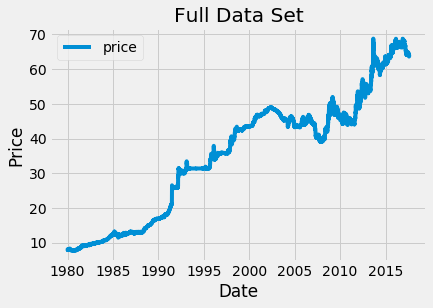

In [522]:
# isolate the closing price, that will be the basis for modeling
df = data_frame[["Price"]]

plt.figure()

plt.plot(df)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Full Data Set')
plt.legend(['price'], loc='upper left')
plt.show()

### Correlogram showing the autocorrelation of the data versus lag
The long, slow delay of the correlogram below is consistent with a non-stationary series. Formally the correlogram alone is not considered sufficient proof of a non-stationary series.  However exchange rate data is often treated as a non-stationary process in the statistical economics literature.

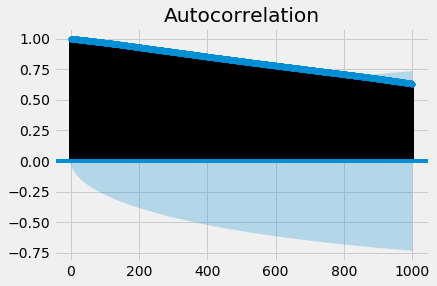

In [523]:
from statsmodels.graphics.tsaplots import plot_acf
#series = Series.from_csv('USD_INR.csv', header=0)

#X = usd_inr.loc[:,'Price'] 
plot_acf(df, lags=1000)
plt.show()

### Selection of training and test data

For now, let's use a simple split, and ensure that we train on an epoch that occurs prior to the test epoch.

In [524]:
# configure
train_pct = 75.0 # pct of data set to be used for training
n_lag = 16
n_seq = 4 # should be '1' for one-step forecasts

# prepare data
scaler, sets, ind = prepare_data(df, int(len(df) * (100 - train_pct)/100), n_lag, n_seq)

In [525]:
sets.tail()

,var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3)
Date,,,,,,,,,,,,,,,,,,,,
2017-08-01,0.858323,0.861268,0.858323,0.857832,0.856654,0.854070,0.853121,0.851616,0.855051,0.855378,0.855706,0.855378,0.854397,0.846871,0.846544,0.849325,0.845890,0.830838,0.833129,0.832147
2017-08-02,0.861268,0.858323,0.857832,0.856654,0.854070,0.853121,0.851616,0.855051,0.855378,0.855706,0.855378,0.854397,0.846871,0.846544,0.849325,0.845890,0.830838,0.833129,0.832147,0.837546
2017-08-03,0.858323,0.857832,0.856654,0.854070,0.853121,0.851616,0.855051,0.855378,0.855706,0.855378,0.854397,0.846871,0.846544,0.849325,0.845890,0.830838,0.833129,0.832147,0.837546,0.832703
2017-08-04,0.857832,0.856654,0.854070,0.853121,0.851616,0.855051,0.855378,0.855706,0.855378,0.854397,0.846871,0.846544,0.849325,0.845890,0.830838,0.833129,0.832147,0.837546,0.832703,0.838200
2017-08-07,0.856654,0.854070,0.853121,0.851616,0.855051,0.855378,0.855706,0.855378,0.854397,0.846871,0.846544,0.849325,0.845890,0.830838,0.833129,0.832147,0.837546,0.832703,0.838200,0.848180


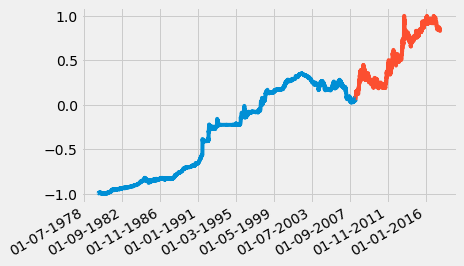

In [526]:
dat = sets.values#dataframe.values

# feature scaling
#sc = MinMaxScaler()
#train_sc = sc.fit_transform(dat[1:train_size])
#test_sc = sc.transform(dat[train_size:])

train_size = int(len(dat) * train_pct/100)
X_train, X_test = dat[0:train_size,0:n_lag], dat[train_size:,0:n_lag] 
y_train, y_test = dat[0:train_size,n_lag:], dat[train_size:,n_lag:] 

# Plot
plt.figure()
plt.plot(ind.values[1:train_size],dat[1:train_size,n_lag])
plt.plot(ind.values[train_size+1:len(dat)],dat[train_size+1:len(dat),n_lag])

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=50))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.show()


In [527]:
i=65
start = 0 if i < n_lag else i-n_lag
X_test.shape

(2420, 16)

In [528]:
# persistence forecast is median val from lag window
def persistence(lag_vals, n_seq):
	med = median(lag_vals)
	return [med for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
#		X, y = test[i, 0:n_lag], test[i, n_lag:]
		X = test[i]
#		start = 0 if i < n_lag else i-n_lag
#		X = test[start, i]
		# make forecast
		forecast = persistence(X, n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts


## evaluate the RMSE for each forecast time step
#def evaluate_forecasts(test, forecasts, n_lag, n_seq):
#	for i in range(n_seq):
#		actual = test[:,(n_lag+i)]
#		predicted = [forecast[i] for forecast in forecasts]
#		rmse = sqrt(mean_squared_error(actual, predicted))
#		print('t+%d RMSE: %f' % ((i+1), rmse))
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))



predictions = make_forecasts(X_test, n_lag, n_seq)
evaluate_forecasts(y_test, predictions, n_lag, n_seq)



t+1 RMSE: 0.024196
t+2 RMSE: 0.026091
t+3 RMSE: 0.027879
t+4 RMSE: 0.029585


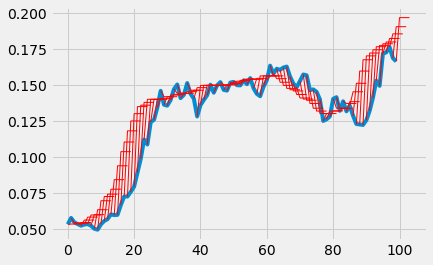

In [529]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series[0:n_test])
	# plot the forecasts in red
	for i in range(n_test):#len(forecasts)):
		off_s = i
#        off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red', linewidth=1)
	# show the plot
	pyplot.show()


plot_forecasts(scaler.fit_transform(df)[train_size:], predictions, 100)


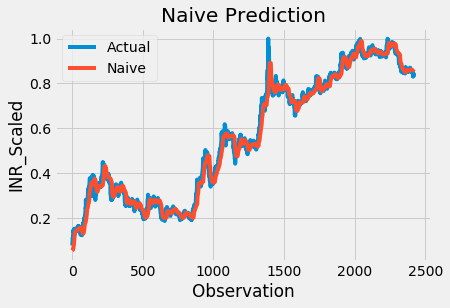

In [530]:
plt.plot(y_test[:,n_seq-1], label='Actual')
plt.plot(DataFrame(predictions).iloc[:,n_seq-1], label='Naive')
plt.title("Naive Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()



In [531]:
K.clear_session()

sgd = optimizers.SGD(lr=0.0001, momentum=0.5, decay=0.0, nesterov=False)

class LossHistory_(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))
        
def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.01
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.05
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

dnn_loss_history_ = LossHistory_()
dnn_lrate_ = LearningRateScheduler(exp_decay)

DNN_model = Sequential()
DNN_model.add(Dense(n_lag*4, input_dim=n_lag, activation='relu'))
DNN_model.add(Dense(n_lag*4, activation='relu'))
#DNN_model.add(Dense(n_lag*2, activation='relu'))
DNN_model.add(Dense(n_seq))
DNN_model.compile(loss='mean_squared_error', optimizer='sgd')

callbacks_list_ = [EarlyStopping(monitor='loss', patience=1, verbose=0),
                   ModelCheckpoint(filepath='best_DNN_model.h5', monitor='loss', save_best_only=True),
                   dnn_loss_history_, dnn_lrate_]

dnn_history = History()
            

dnn_history = DNN_model.fit(X_train, y_train,
                        validation_split=0.20,
                        epochs=500,
                        batch_size=50, verbose=0, callbacks=callbacks_list_, shuffle=False)


lr: 0.009900498337491681
lr: 0.009801986733067553
lr: 0.009704455335485081
lr: 0.009607894391523233
lr: 0.00951229424500714
lr: 0.009417645335842488
lr: 0.009323938199059483
lr: 0.009231163463866357
lr: 0.009139311852712282
lr: 0.009048374180359595
lr: 0.008958341352965282
lr: 0.008869204367171575
lr: 0.008780954309205613
lr: 0.00869358235398806
lr: 0.008607079764250578
lr: 0.008521437889662113
lr: 0.008436648165963838
lr: 0.008352702114112721
lr: 0.008269591339433623
lr: 0.008187307530779819
lr: 0.00810584245970187
lr: 0.008025187979624785
lr: 0.00794533602503334
lr: 0.007866278610665535
lr: 0.007788007830714049
lr: 0.007710515858035663
lr: 0.007633794943368532
lr: 0.007557837414557255
lr: 0.007482635675785653
lr: 0.007408182206817179
lr: 0.007334469562242893
lr: 0.00726149037073691
lr: 0.007189237334319262
lr: 0.007117703227626096
lr: 0.007046880897187135
lr: 0.0069767632607103105
lr: 0.006907343306373547
lr: 0.006838614092123559
lr: 0.006770568744981647
lr: 0.006703200460356393
lr: 

lr: 0.00039955058260653895
lr: 0.0003955749878839873
lr: 0.00039163895098987065
lr: 0.0003877420783172201
lr: 0.00038388398017552057
lr: 0.0003800642707517431
lr: 0.000376282568071762
lr: 0.00037253849396215807
lr: 0.00036883167401239995
lr: 0.00036516173753740406
lr: 0.00036152831754046415
lr: 0.000357931050676553
lr: 0.00035436957721598643
lr: 0.00035084354100845027
lr: 0.00034735258944738564
lr: 0.0003438963734347271
lr: 0.00034047454734599346
lr: 0.000337086768995724
lr: 0.0003337326996032608
lr: 0.00033041200375886934
lr: 0.0003271243493901982
lr: 0.0003238694077290704
lr: 0.0003206468532786077
lr: 0.0003174563637806794
lr: 0.0003142976201836771
lr: 0.0003111703066106086
lr: 0.0003080741103275108
lr: 0.00030500872171217484
lr: 0.00030197383422318503
lr: 0.0002989691443692631
lr: 0.00029599435167892
lr: 0.00029304915867040747
lr: 0.0002901332708219705
lr: 0.00028724639654239425
lr: 0.0002843882471418451
lr: 0.000281558536803001
lr: 0.00027875698255247017
lr: 0.00027598330423249287


dict_keys(['val_loss', 'loss', 'lr'])


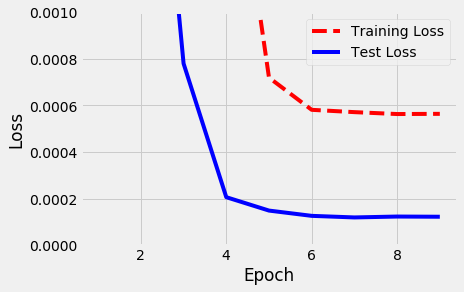

In [532]:
# returns a compiled model
# identical to the previous one
DNN_model = load_model('best_DNN_model.h5')

plt.figure()

# list all data in history
print(history.history.keys())
# summarize history for accuracy
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,0.001])
plt.show();

# Evaluation

t+1 RMSE: 0.052666
t+2 RMSE: 0.161183
t+3 RMSE: 0.052363
t+4 RMSE: 0.165633


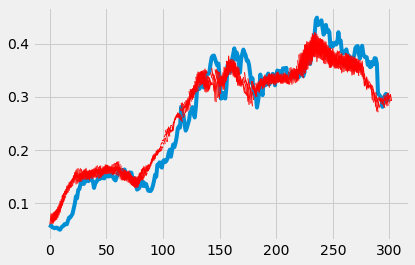

In [533]:
# evaluate the persistence model
def make_ann_forecasts(model, X_in, n_lag, n_seq):
	forecasts = list()
	for i in range(len(X_in)):
#		X = X_in[i:(i+1),:]
		X = X_in[i].reshape(1,n_lag)
		# make forecast
		forecast = model.predict(X)
		# store the forecast
		forecasts.append(forecast[0])
	return forecasts

        
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series[0:n_test])
	# plot the forecasts in red
	for i in range(n_test):#len(forecasts)):
		off_s = i
		off_e = off_s + len(forecasts[i])
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red', linewidth=1)
	# show the plot
	pyplot.show()
        
forecasts = make_ann_forecasts(DNN_model, X_test, n_lag, n_seq)
# evaluate forecasts
evaluate_forecasts(y_test, forecasts, n_lag, n_seq)


#plot_forecasts(df['Price'][train_size:], forecasts,100)




scaled_values = scaler.fit_transform(df.values)
plot_forecasts(scaled_values[train_size:], forecasts, 300)#scaler.fit_transform(df.values)

#plot_forecasts(scaler.fit_transform(df)[train_size:], forecasts, 100)


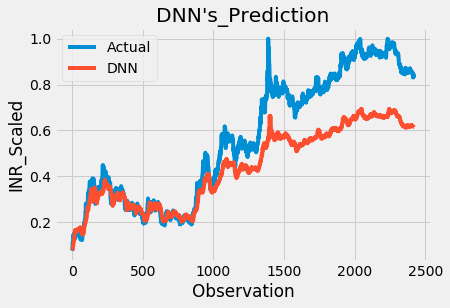

In [534]:

y_pred_test_DNN = DNN_model.predict(X_test)

plt.plot(y_test[:,n_seq-1], label='Actual')
plt.plot(y_pred_test_DNN[:,n_seq-1], label='DNN')
plt.title("DNN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()


In [535]:
#n_test = int(len(df) * (100 - train_pct)/100)
#scaled_values = scaler.fit_transform(df.values)
#
## extract raw values
##values = scaled_values.values
#idx = df.index
#
#supervised = series_to_supervised(scaled_values, idx, n_lag, n_seq)
#       
#supervised_values = supervised.values
#index = supervised.index
#
#train_test_data = []
#for i in range(1): #supervised_values.shape[0] - n_lag):
##    train_test_data.append(supervised_values[i:i+n_lag, i+n_lag:i+n_lag+n_seq])
#    train_test_data.append(supervised_values[i])


In [536]:
scaler = StandardScaler()#with_mean=False,with_std=False)

series = df
n_test = int(len(df) * (100 - train_pct)/100)
diff_series = difference(series.values, 0)
diff_values = diff_series.values
diff_values = diff_values.reshape(len(diff_values), 1)    

len(diff_values)

9697

In [537]:
# transform series into sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq, scaler):
    
#    diff_series = difference(series.values, 0)
#    diff_values = diff_series.values
#    diff_values = diff_values.reshape(len(diff_values), 1)    
    
    scaled_values = scaler.fit_transform(series.values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
        
    # extract raw values
    idx = series.index

    supervised = series_to_supervised(scaled_values, idx, n_lag, n_seq)
       
    supervised_values = supervised.values
    index = supervised.index
    
    train_test_data = []
    for i in range(supervised_values.shape[0] - n_lag):
#        train_test_data.append(supervised_values[i:i+n_lag, i+n_lag:i+n_lag+n_seq])
        train_test_data.append(supervised_values[i])

    return np.array(train_test_data), index


#scaler = StandardScaler()#with_mean=False,with_std=False)
scaler = MinMaxScaler(feature_range=(-1, 1))
# prepare data
sets, ind = prepare_data(df, int(len(df) * (100 - train_pct)/100), n_lag, n_seq, scaler)
sets.shape

train_size = int(len(sets) * train_pct/100)
X_train, X_test = sets[0:train_size,0:n_lag], sets[train_size:,0:n_lag] 
y_train, y_test = sets[0:train_size,n_lag:], sets[train_size:,n_lag:] 

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_seq)
#X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], n_seq)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

X_train.shape



(7246, 16, 1)

In [538]:
sgd = optimizers.SGD(lr=0.0001, momentum=0.5, decay=0.0, nesterov=False)
rmsp = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)
adm = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

class LossHistory_(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))
        
def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.01
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

#def step_decay(epoch):
#    initial_lrate = 0.01
#    drop = 0.05
#    epochs_drop = 10.0
#    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#    return lrate

def step_decay(epoch, lr):
    # initial_lrate = 1.0 # no longer needed
    drop = 0.5
    epochs_drop = 2.0
    lrate = lr * math.pow(drop, 
    math.floor((1+epoch)/epochs_drop))
    return lrate

loss_history_ = LossHistory_()
#lrate_ = LearningRateScheduler(schedule=lambda epoch: 0.01 * (0.9 ** epoch))
lrate_ = LearningRateScheduler(exp_decay)
#lrate = LearningRateScheduler(step_decay)
callbacks_list_ = [EarlyStopping(monitor='loss', patience=1, verbose=0),
                   ModelCheckpoint(filepath='best_GRU_model.h5', monitor='loss', save_best_only=True),
                   loss_history_, lrate_]

history = History()

# The GRU architecture
GRU_model = Sequential()
# First GRU layer with Dropout regularisation
GRU_model.add(GRU(units=4*n_lag, return_sequences=True, input_shape=(X_train.shape[1], 1)))
GRU_model.add(Dropout(0.2))
## Second GRU layer
GRU_model.add(GRU(units=4*n_lag, return_sequences=True))
#GRU_model.add(Dropout(0.2))
## Third GRU layer
GRU_model.add(GRU(units=4*n_lag, return_sequences=True))
#GRU_model.add(Dropout(0.2))
## Fourth GRU layer
GRU_model.add(GRU(units=4*n_lag))
#GRU_model.add(Dropout(0.2))
# The output layer
GRU_model.add(Dense(units=n_seq))

# Compiling the RNN
#['accuracy', 'mean_squared_error', 'val_loss']
GRU_model.compile(optimizer=sgd, loss='mean_squared_error' )
GRU_model.summary()

# Fitting to the training set
history = GRU_model.fit(X_train,
                 y_train,
                 shuffle=False,
                 validation_split=0.20,
                 epochs=500,
                 batch_size=50,
                 callbacks=callbacks_list_)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 16, 64)            12672     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 16, 64)            24768     
_________________________________________________________________
gru_3 (GRU)                  (None, 16, 64)            24768     
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
Total params: 87,236
Trainable params: 87,236
Non-trainable params: 0
_________________________________________________________________
Train 

dict_keys(['val_loss', 'loss', 'lr'])


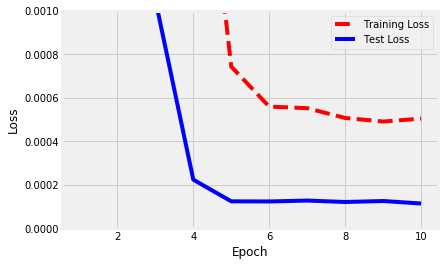

In [539]:
%matplotlib inline

# returns a compiled model
GRU_model = load_model('best_GRU_model.h5')

plt.figure()

# list all data in history
print(history.history.keys())
# summarize history for accuracy
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,0.001])
plt.show();


In [540]:
# evaluate the model
def make_gru_forecasts(model, X, n_lag, n_seq):
    forecasts = list()
    for i in range(len(X)):
        # make forecast
        forecast = model.predict(X[i].reshape(1, X.shape[1], 1))[0,:]
        # store the forecast
        forecasts.append(forecast)
    return forecasts

### evaluate the RMSE for each forecast time step
#def evaluate_forecasts(test, forecasts, n_lag, n_seq):
#    for i in range(n_seq):
#        actual = [row[i] for row in test]
#        predicted = [forecast[i] for forecast in forecasts]
#        rmse = sqrt(mean_squared_error(actual, predicted))
#        print('t+%d RMSE: %f' % ((i+1), rmse))
        
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series[0:n_test])
	# plot the forecasts in red
	for i in range(n_test):#len(forecasts)):
		off_s = i
		off_e = off_s + len(forecasts[i])
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red', linewidth=1)
	# show the plot
	pyplot.show()

In [541]:
forecasts[0].tolist()

off_s = len(df) - 10 + 0 - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [df.values[off_s]] + forecasts[0].tolist()
len(df)

9697

In [542]:
forecasts = make_gru_forecasts(GRU_model, X_test, n_lag, n_seq)

evaluate_forecasts(y_test, forecasts, n_lag, n_seq)

t+1 RMSE: 0.056287
t+2 RMSE: 0.053493
t+3 RMSE: 0.046347
t+4 RMSE: 0.061512


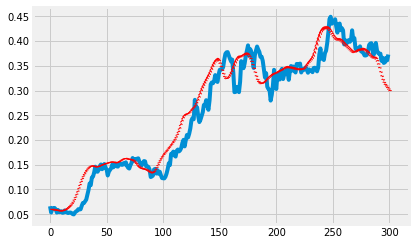

In [543]:
scaled_values = scaler.fit_transform(df.values)
plot_forecasts(scaled_values[train_size:], forecasts, 300)#scaler.fit_transform(df.values)


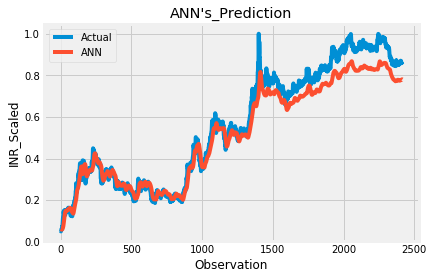

In [544]:
X_test_reshape = np.reshape(X_test, (X_test.shape[0], n_lag, 1))
y_pred_test_GRU = GRU_model.predict(X_test_reshape)

plt.plot(y_test[:,n_seq-1], label='Actual')
plt.plot(y_pred_test_GRU[:,n_seq-1], label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()


In [546]:
df = pd.read_csv('train_1.csv')

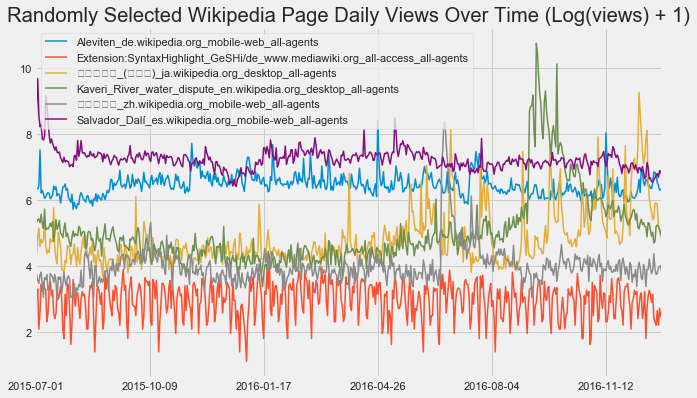

In [548]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]

def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['Page'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 6)

In [549]:
from datetime import timedelta

pred_steps = 60 
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)



In [550]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [551]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':60})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [552]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 16)     32          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 32)     1056        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [553]:

first_n_samples = 120000
batch_size = 2**11
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

Train on 96000 samples, validate on 24000 samples
Epoch 1/10
92160/96000 [===========================>..] - ETA: 1:01 - loss: 0.4420

KeyboardInterrupt: 